In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Importation des données

In [ ]:
# import yfinance as yf
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# # Télécharger les données
# df = yf.download("^GDAXI", start="2000-01-01", end="2026-01-01")

# # Calculer les rendements logarithmiques
# df['returns'] = np.log(df['Close'] / df['Close'].shift(1))


C:\Users\UltraBook 3.1\AppData\Local\Temp\ipykernel_17236\1430733673.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^GDAXI", start="2000-01-01", end="2026-01-01")
[*********************100%***********************]  1 of 1 completed


In [116]:
df = pd.read_csv('../data/dax.csv')
df['Date']=pd.to_datetime(df['Date'],yearfirst=True)
df = df.set_index(df['Date'])
df.head()

,Date,Close,High,Low,Open,Volume,returns
Date,,,,,,,
2000-01-03,2000-01-03,6750.759766,7159.330078,6720.870117,6961.720215,43072500,NaN
2000-01-04,2000-01-04,6586.950195,6755.359863,6510.459961,6747.240234,46678400,-0.024565
2000-01-05,2000-01-05,6502.069824,6585.850098,6388.910156,6585.850098,52682800,-0.012970
2000-01-06,2000-01-06,6474.919922,6539.310059,6402.629883,6501.450195,41180600,-0.004184
2000-01-07,2000-01-07,6780.959961,6791.529785,6470.140137,6489.939941,56058900,0.046182


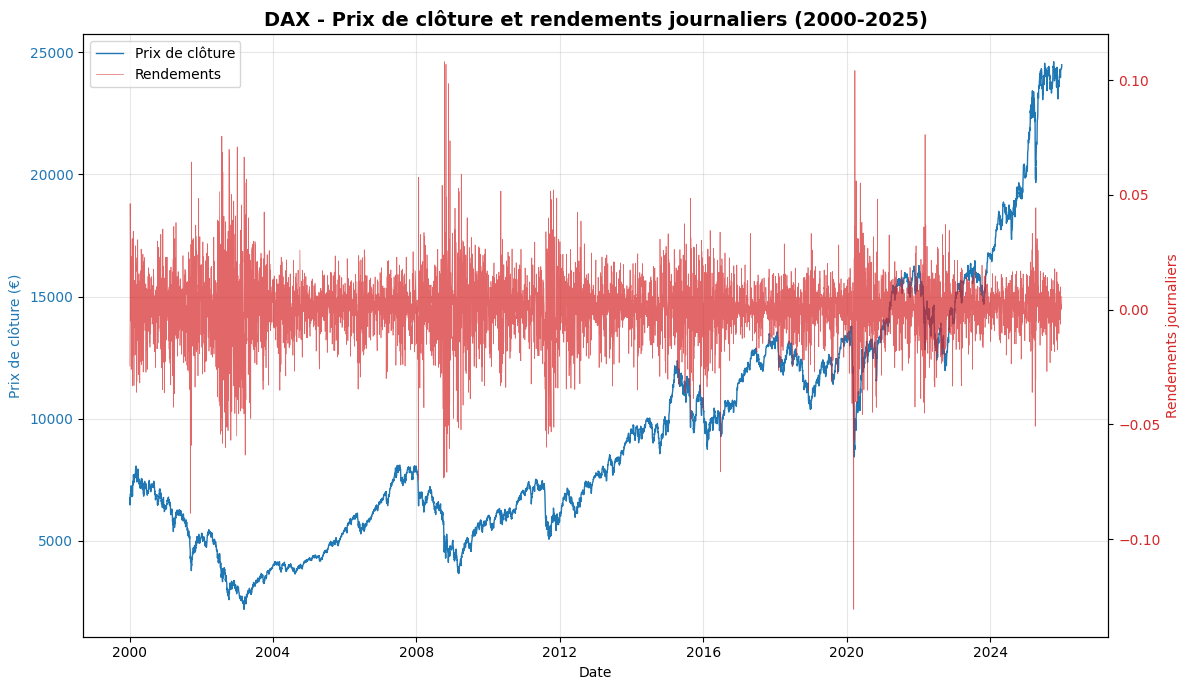

In [ ]:
# Créer la figure avec deux axes Y
fig, ax1 = plt.subplots(figsize=(12, 7))

# Premier axe Y (gauche) - Prix de clôture
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Prix de clôture (€)', color=color)
ax1.plot(df['Date'], df['Close'], color=color, linewidth=1, label='Prix de clôture')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Deuxième axe Y (droite) - Rendements
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Rendements journaliers', color=color)
ax2.plot(df['Date'], df['returns'], color=color, alpha=0.7, linewidth=0.5, label='Rendements')
ax2.tick_params(axis='y', labelcolor=color)

# Titre et légende
plt.title('DAX - Prix de clôture et rendements journaliers (2000-2025)', fontsize=14, fontweight='bold')

# Créer une légende combinée
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Etude volatilité

Les périodes de forte volatilité sont détectées automatiquement en identifiant les instants où une mesure locale de dispersion dépasse un seuil extrême défini par un quantile élevé de sa distribution empirique. Cette approche permet de capturer les régimes de marché caractérisés par une accumulation d’événements extrêmes.

In [90]:
def plot_volatility_periods(returns, periods, title=None):
    """
    returns : pd.Series (index = dates)
    periods : liste de tuples (start_date, end_date)
    """

    plt.figure(figsize=(12, 5))
    plt.plot(returns.index, returns.values, label="Rendements", linewidth=1)

    # Zones de forte volatilité
    for i, (start, end) in enumerate(periods):
        plt.axvspan(start, end, alpha=0.3, color = 'red',
                    label="Forte volatilité" if i == 0 else None)

    plt.axhline(0, linestyle="--", linewidth=0.8)
    plt.xlabel("Date")
    plt.ylabel("Rendement")
    plt.title(title if title else "Périodes de forte volatilité")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [60]:
returns = df['returns']
returns.index = df['Date']

## Détection des périodes de forte volatilité sur des fenetres glissantes

La volatilité des rendements étant variable dans le temps, une mesure locale est estimée à l’aide d’une volatilité calculée sur une fenêtre glissante. À chaque date \(t\), la volatilité roulante \(\sigma_t\) correspond à l’écart-type des rendements observés sur les \(h\) périodes précédentes.

Afin d’identifier les régimes de marché instables, un seuil de forte volatilité est défini comme un quantile élevé de la distribution empirique de \(\sigma_t\). Une date est considérée comme appartenant à une phase de forte volatilité lorsque \(\sigma_t\) dépasse ce seuil.

Les périodes de forte volatilité sont ensuite définies comme des intervalles de temps continus pour lesquels cette condition est vérifiée.


In [59]:
def detect_high_volatility_periods(
    returns,
    window=20,
    quantile=0.95
):
    """
    returns : pd.Series (index = dates)
    window  : taille de la fenêtre roulante
    quantile: seuil de forte volatilité
    """

    # 1️⃣ Volatilité roulante (RMS)
    rolling_vol = np.sqrt(
        returns.rolling(window).mean()**2 +
        returns.rolling(window).var()
    )

    # Version encore plus simple et classique :
    # rolling_vol = returns.rolling(window).std()

    # 2️⃣ Seuil extrême
    threshold = rolling_vol.quantile(quantile)

    # 3️⃣ Indicateur forte volatilité
    high_vol = rolling_vol > threshold

    # 4️⃣ Extraction des périodes continues
    periods = []
    in_period = False

    for date, is_high in high_vol.items():
        if is_high and not in_period:
            start = date
            in_period = True
        elif not is_high and in_period:
            end = date
            periods.append((start, end))
            in_period = False

    # Cas où la série finit en période de forte vol
    if in_period:
        periods.append((start, high_vol.index[-1]))

    return periods


In [103]:
periods1 = detect_high_volatility_periods(returns,window=80)

for i, (start, end) in enumerate(periods1, 1):
    print(f"Période de forte volatilité n°{i} : du {start.date()} au {end.date()}")


Période de forte volatilité n°1 : du 2002-08-08 au 2003-02-13
Période de forte volatilité n°2 : du 2003-02-14 au 2003-02-17
Période de forte volatilité n°3 : du 2003-03-21 au 2003-04-28
Période de forte volatilité n°4 : du 2008-10-28 au 2009-03-18
Période de forte volatilité n°5 : du 2011-11-11 au 2011-11-25
Période de forte volatilité n°6 : du 2011-11-28 au 2011-11-29
Période de forte volatilité n°7 : du 2011-11-30 au 2011-12-01
Période de forte volatilité n°8 : du 2020-04-06 au 2020-07-08


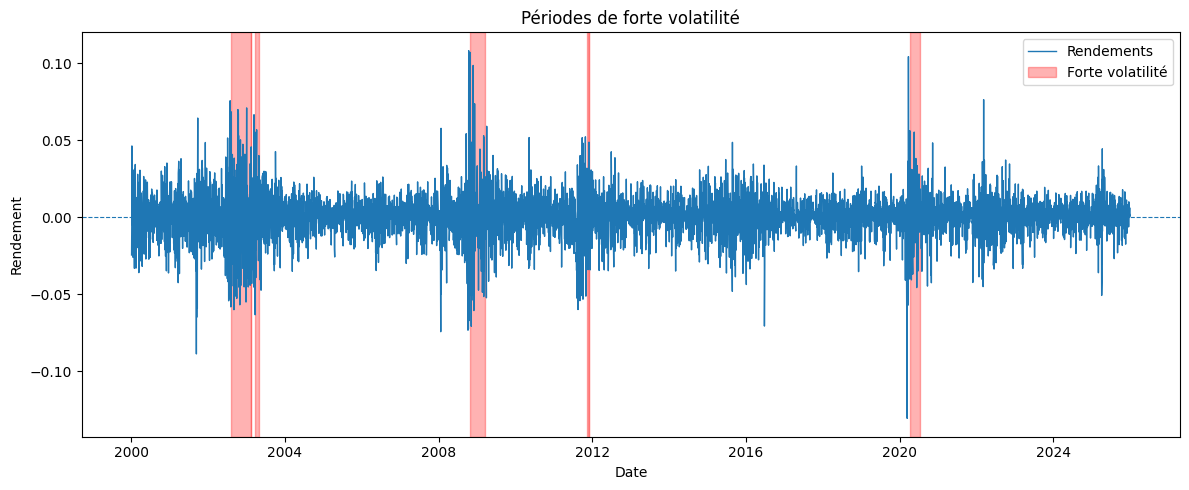

In [104]:
plot_volatility_periods(returns, periods1)

## Détection des périodes de forte volatilité – Approche POT

La forte volatilité se manifeste par une fréquence élevée de rendements de grande amplitude. On considère donc la série des valeurs absolues des rendements \(X_t = |r_t|\) et on applique une approche de type Peaks Over Threshold (POT).

Un seuil élevé \(u\) est défini comme un quantile de la distribution empirique de \(X_t\). Les observations telles que \(X_t > u\) sont interprétées comme des événements extrêmes.

Les périodes de forte volatilité sont identifiées en comptabilisant, sur une fenêtre glissante, le nombre d’excès au-dessus du seuil. Un intervalle de temps est considéré comme un régime de forte volatilité lorsque cette fréquence dépasse un niveau donné.


In [94]:
def detect_extreme_volatility_periods(
    returns,
    window=20,
    quantile=0.95,
    min_exceedances=4
):
    """
    returns : pd.Series (index = dates)
    window  : fenêtre glissante
    quantile: seuil POT
    min_exceedances : nombre minimal d'excès dans la fenêtre
    """

    # 1️⃣ Valeurs absolues
    abs_returns = returns.abs()

    # 2️⃣ Seuil POT
    threshold = abs_returns.quantile(quantile)

    # 3️⃣ Indicateur d'excès
    exceedances = abs_returns > threshold

    # 4️⃣ Comptage glissant des excès
    rolling_exceedances = exceedances.rolling(window).sum()

    # 5️⃣ Régime de forte volatilité
    high_vol = rolling_exceedances >= min_exceedances

    # 6️⃣ Extraction des périodes continues
    periods = []
    in_period = False

    for date, is_high in high_vol.items():
        if is_high and not in_period:
            start = date
            in_period = True
        elif not is_high and in_period:
            end = date
            periods.append((start, end))
            in_period = False

    if in_period:
        periods.append((start, high_vol.index[-1]))

    return periods


In [105]:
periods2 = detect_extreme_volatility_periods(returns,window=80)

for i, (start, end) in enumerate(periods2, 1):
    print(f"Période de forte volatilité n°{i} : du {start.date()} au {end.date()}")


Période de forte volatilité n°1 : du 2000-04-25 au 2000-07-06
Période de forte volatilité n°2 : du 2000-12-05 au 2001-07-20
Période de forte volatilité n°3 : du 2001-09-11 au 2002-04-05
Période de forte volatilité n°4 : du 2002-06-17 au 2003-08-28
Période de forte volatilité n°5 : du 2003-09-24 au 2003-10-22
Période de forte volatilité n°6 : du 2003-11-17 au 2004-01-19
Période de forte volatilité n°7 : du 2008-02-05 au 2008-06-06
Période de forte volatilité n°8 : du 2008-10-06 au 2009-10-12
Période de forte volatilité n°9 : du 2010-05-27 au 2010-08-30
Période de forte volatilité n°10 : du 2011-08-08 au 2012-04-03
Période de forte volatilité n°11 : du 2012-04-04 au 2012-04-13
Période de forte volatilité n°12 : du 2012-04-23 au 2012-04-25
Période de forte volatilité n°13 : du 2012-06-01 au 2012-10-22
Période de forte volatilité n°14 : du 2015-01-08 au 2015-02-11
Période de forte volatilité n°15 : du 2015-07-10 au 2016-01-18
Période de forte volatilité n°16 : du 2016-02-08 au 2016-04-27
P

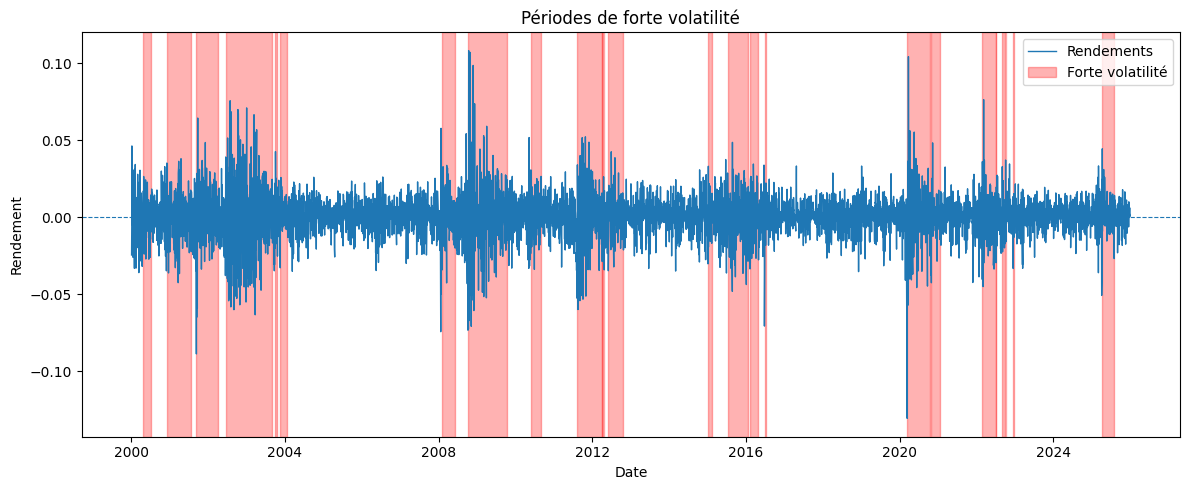

In [106]:
plot_volatility_periods(returns, periods2)

## Détection des périodes de forte volatilité – Approche GARCH

La volatilité des rendements est modélisée à l’aide d’un modèle GARCH(1,1), permettant de capturer la dépendance temporelle et la persistance de la volatilité.

À partir de la volatilité conditionnelle estimée, un seuil de forte volatilité est défini comme un quantile élevé de sa distribution empirique. Les périodes de forte volatilité correspondent alors aux intervalles de temps durant lesquels la volatilité conditionnelle dépasse ce seuil.


In [75]:
from arch import arch_model

def detect_garch_volatility_periods(
    returns,
    quantile=0.95
):
    """
    returns : pd.Series (index = dates)
    """
    returns = returns.copy()
    returns = returns.dropna()

    # 1️⃣ Estimation GARCH(1,1)
    model = arch_model(returns * 100, vol="Garch", p=1, q=1, mean="Zero")
    res = model.fit(disp="off")

    # 2️⃣ Volatilité conditionnelle
    cond_vol = res.conditional_volatility
    cond_vol.index = returns.index

    # 3️⃣ Seuil extrême
    threshold = cond_vol.quantile(quantile)

    # 4️⃣ Régimes de forte volatilité
    high_vol = cond_vol > threshold

    # 5️⃣ Extraction des périodes continues
    periods = []
    in_period = False

    for date, is_high in high_vol.items():
        if is_high and not in_period:
            start = date
            in_period = True
        elif not is_high and in_period:
            end = date
            periods.append((start, end))
            in_period = False

    if in_period:
        periods.append((start, high_vol.index[-1]))

    return periods, cond_vol


In [107]:
periods3, cond_vol = detect_garch_volatility_periods(returns,quantile=0.95)

for i, (start, end) in enumerate(periods3, 1):
    print(f"Période de forte volatilité n°{i} : du {start.date()} au {end.date()}")


Période de forte volatilité n°1 : du 2001-09-12 au 2001-10-10
Période de forte volatilité n°2 : du 2001-10-11 au 2001-10-12
Période de forte volatilité n°3 : du 2002-07-08 au 2002-07-10
Période de forte volatilité n°4 : du 2002-07-11 au 2002-07-15
Période de forte volatilité n°5 : du 2002-07-16 au 2002-11-20
Période de forte volatilité n°6 : du 2002-11-28 au 2002-11-29
Période de forte volatilité n°7 : du 2002-12-11 au 2002-12-12
Période de forte volatilité n°8 : du 2002-12-17 au 2002-12-18
Période de forte volatilité n°9 : du 2002-12-19 au 2002-12-27
Période de forte volatilité n°10 : du 2002-12-30 au 2003-01-15
Période de forte volatilité n°11 : du 2003-01-20 au 2003-01-21
Période de forte volatilité n°12 : du 2003-02-20 au 2003-02-21
Période de forte volatilité n°13 : du 2003-02-26 au 2003-02-27
Période de forte volatilité n°14 : du 2003-03-14 au 2003-04-17
Période de forte volatilité n°15 : du 2008-01-22 au 2008-01-23
Période de forte volatilité n°16 : du 2008-01-24 au 2008-02-01
P

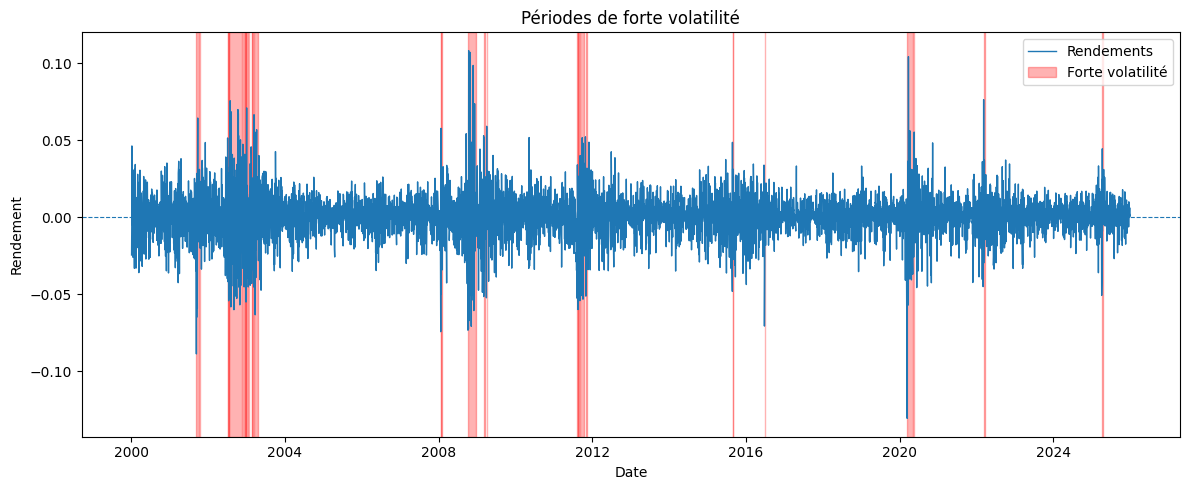

In [108]:
plot_volatility_periods(returns, periods3)

# train test split

In [117]:
bornes = ['2016-07-06','2020-03-06','2020-10-14']

train = df[(df['Date'] >= bornes[0]) & 
                     (df['Date'] < bornes[1])]
test = df[(df['Date'] >= bornes[1]) & 
                    (df['Date'] <= bornes[2])]

print(f"Train shape: {train.shape[0]}, Période: {train.index[0]} à {train.index[-1]}")
print(f"Test shape: {test.shape[0]}, Période: {test.index[0]} à {test.index[-1]}")

Train shape: 926, Période: 2016-07-06 00:00:00 à 2020-03-05 00:00:00
Test shape: 155, Période: 2020-03-06 00:00:00 à 2020-10-14 00:00:00


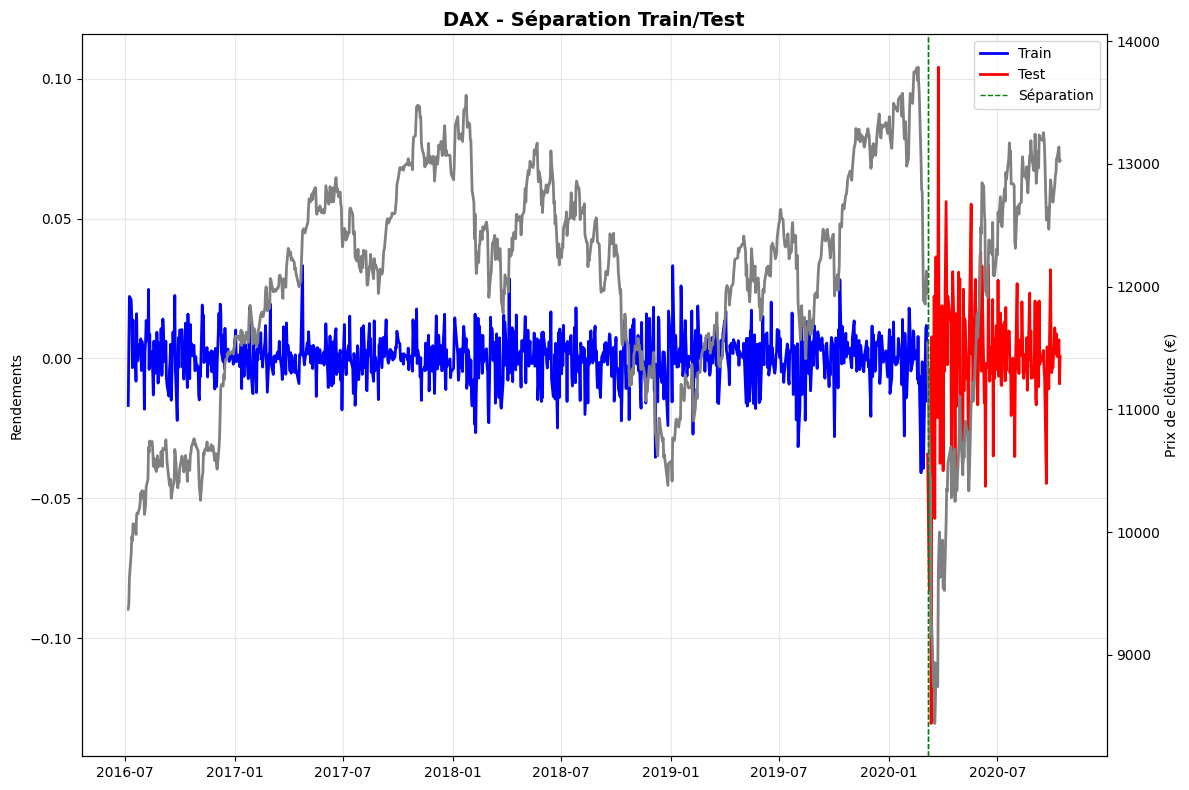

In [128]:
# Créer un graphique montrant les périodes train/test
fig, ax2 = plt.subplots(figsize=(12, 8))

# Graphique complet



ax2.plot(train.index, train['returns'], color='blue', linewidth=2, label='Train')
ax2.plot(test.index, test['returns'], color='red', linewidth=2, label='Test')
ax2.axvline(x=pd.Timestamp(bornes[1]), color='green', linestyle='--', 
            linewidth=1, label='Séparation')
ax2.set_ylabel('Rendements')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax1 = ax2.twinx()
ax1.plot(train.index, train['Close'], color='gray', linewidth=2)
ax1.plot(test.index, test['Close'], color='gray', linewidth=2)
ax1.axvline(x=pd.Timestamp(bornes[1]), color='green', linestyle='--', 
            linewidth=1, label='Séparation')
ax1.set_title('DAX - Séparation Train/Test', fontsize=14, fontweight='bold')
ax1.set_ylabel('Prix de clôture (€)')


plt.tight_layout()
plt.show()

In [132]:
# Fonction pour des statistiques complètes
def detailed_stats(dataframe, name):
    stats_dict = {}
    
    for column in ['Close', 'returns']:
        if column in dataframe.columns:
            col_data = dataframe[column].dropna()
            stats_dict[f'{column}_mean'] = col_data.mean()
            stats_dict[f'{column}_std'] = col_data.std()
            stats_dict[f'{column}_min'] = col_data.min()
            stats_dict[f'{column}_max'] = col_data.max()
            stats_dict[f'{column}_median'] = col_data.median()
            stats_dict[f'{column}_skew'] = col_data.skew()
            stats_dict[f'{column}_kurtosis'] = col_data.kurtosis()
            stats_dict[f'{column}_q25'] = col_data.quantile(0.25)
            stats_dict[f'{column}_q75'] = col_data.quantile(0.75)
            stats_dict[f'{column}_count'] = len(col_data)
    
    return pd.DataFrame(stats_dict, index=[name])

# Calculer les statistiques
train_stats = detailed_stats(train[['returns']], 'Train')
test_stats = detailed_stats(test[['returns']], 'Test')

# Combiner et afficher
comparison_stats = pd.concat([train_stats, test_stats])
print("\nCOMPARAISON DES STATISTIQUES TRAIN/TEST :")
print(comparison_stats.round(4))


COMPARAISON DES STATISTIQUES TRAIN/TEST :
       returns_mean  returns_std  returns_min  returns_max  returns_median  \
Train        0.0002       0.0089      -0.0409       0.0332          0.0007   
Test         0.0006       0.0243      -0.1305       0.1041          0.0007   

       returns_skew  returns_kurtosis  returns_q25  returns_q75  returns_count  
Train       -0.4131            1.8855      -0.0042       0.0053            926  
Test        -0.8892            7.4385      -0.0071       0.0124            155  


C:\Users\UltraBook 3.1\AppData\Local\Temp\ipykernel_17236\2805866505.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(data_to_plot, labels=['Train', 'Test'])


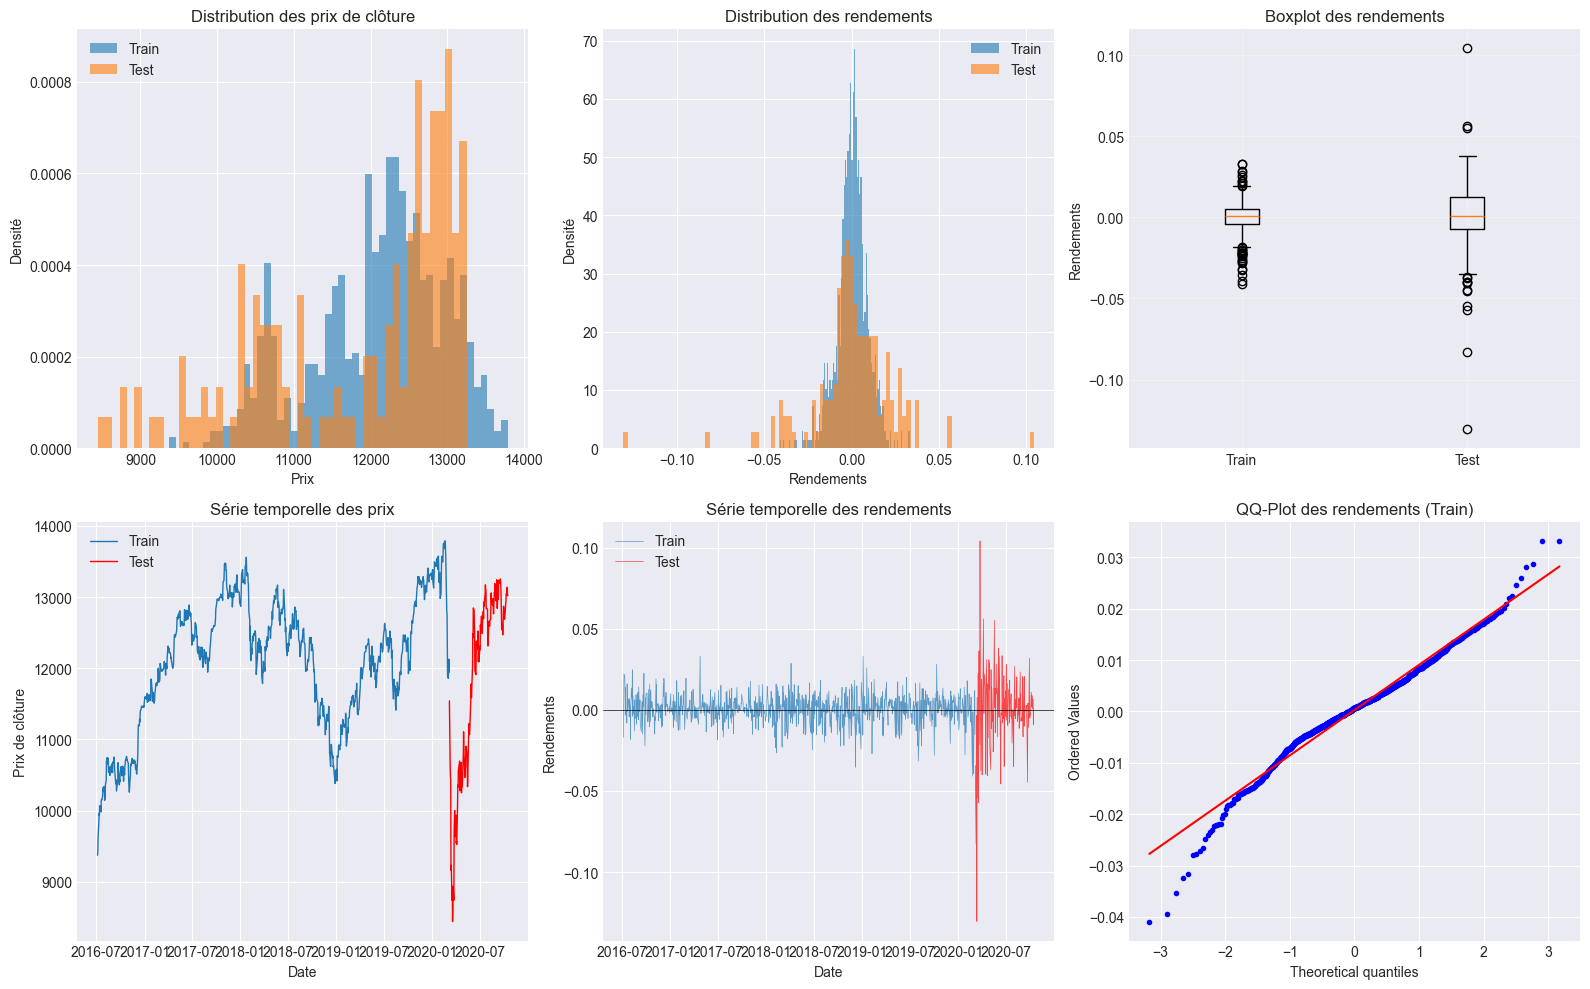

In [133]:
# Configuration du style
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(16, 10))

# 1. Distribution des prix de clôture
ax1 = plt.subplot(2, 3, 1)
ax1.hist(train['Close'].dropna(), bins=50, alpha=0.6, label='Train', density=True)
ax1.hist(test['Close'].dropna(), bins=50, alpha=0.6, label='Test', density=True)
ax1.set_title('Distribution des prix de clôture')
ax1.set_xlabel('Prix')
ax1.set_ylabel('Densité')
ax1.legend()

# 2. Distribution des rendements
ax2 = plt.subplot(2, 3, 2)
ax2.hist(train['returns'].dropna(), bins=100, alpha=0.6, label='Train', density=True)
ax2.hist(test['returns'].dropna(), bins=100, alpha=0.6, label='Test', density=True)
ax2.set_title('Distribution des rendements')
ax2.set_xlabel('Rendements')
ax2.set_ylabel('Densité')
ax2.legend()

# 3. Boxplot des rendements
ax3 = plt.subplot(2, 3, 3)
data_to_plot = [train['returns'].dropna(), test['returns'].dropna()]
ax3.boxplot(data_to_plot, labels=['Train', 'Test'])
ax3.set_title('Boxplot des rendements')
ax3.set_ylabel('Rendements')
ax3.grid(True, alpha=0.3)

# 4. Série temporelle des prix
ax4 = plt.subplot(2, 3, 4)
ax4.plot(train.index, train['Close'], label='Train', linewidth=1)
ax4.plot(test.index, test['Close'], label='Test', linewidth=1, color='red')
ax4.set_title('Série temporelle des prix')
ax4.set_xlabel('Date')
ax4.set_ylabel('Prix de clôture')
ax4.legend()

# 5. Série temporelle des rendements
ax5 = plt.subplot(2, 3, 5)
ax5.plot(train.index, train['returns'], label='Train', linewidth=0.5, alpha=0.7)
ax5.plot(test.index, test['returns'], label='Test', linewidth=0.5, alpha=0.7, color='red')
ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax5.set_title('Série temporelle des rendements')
ax5.set_xlabel('Date')
ax5.set_ylabel('Rendements')
ax5.legend()

# 6. QQ-Plot pour la normalité des rendements
ax6 = plt.subplot(2, 3, 6)
stats.probplot(train['returns'].dropna(), dist="norm", plot=ax6)
ax6.set_title('QQ-Plot des rendements (Train)')
ax6.get_lines()[0].set_markersize(3)

plt.tight_layout()
plt.show()

In [134]:
# Calcul des métriques de risque
def calculate_risk_metrics(returns_series, name, risk_free_rate=0.02/252):
    """Calcule les métriques de risque"""
    returns = returns_series.dropna()
    
    metrics = {
        'Période': name,
        'Nb_observations': len(returns),
        'Rendement_moyen_journalier': returns.mean(),
        'Rendement_annualisé': returns.mean() * 252,
        'Volatilité_journalière': returns.std(),
        'Volatilité_annualisée': returns.std() * np.sqrt(252),
        'Ratio_de_Sharpe': (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252),
        'Skewness': returns.skew(),
        'Kurtosis': returns.kurtosis(),
        'VaR_95%': returns.quantile(0.05),
        'ES_95%': returns[returns <= returns.quantile(0.05)].mean(),
        'Maximum_Drawdown': (returns.cumsum().expanding().max() - returns.cumsum()).max(),
        'Ratio_Sortino': returns.mean() / returns[returns < 0].std()
    }
    
    return metrics

# Calculer pour train et test
train_metrics = calculate_risk_metrics(train['returns'], 'Train')
test_metrics = calculate_risk_metrics(test['returns'], 'Test')

# Créer un DataFrame comparatif
risk_comparison = pd.DataFrame([train_metrics, test_metrics]).set_index('Période')
print("\n" + "=" * 60)
print("COMPARAISON DES MÉTRIQUES DE RISQUE")
print("=" * 60)
print(risk_comparison.round(4))


COMPARAISON DES MÉTRIQUES DE RISQUE
         Nb_observations  Rendement_moyen_journalier  Rendement_annualisé  \
Période                                                                     
Train                926                      0.0002               0.0614   
Test                 155                      0.0006               0.1411   

         Volatilité_journalière  Volatilité_annualisée  Ratio_de_Sharpe  \
Période                                                                   
Train                    0.0089                 0.1413           0.2928   
Test                     0.0243                 0.3856           0.3142   

         Skewness  Kurtosis  VaR_95%  ES_95%  Maximum_Drawdown  Ratio_Sortino  
Période                                                                        
Train     -0.4131    1.8855  -0.0153 -0.0210            0.2671         0.0369  
Test      -0.8892    7.4385  -0.0399 -0.0621            0.3128         0.0267  


In [135]:
from scipy.stats import ttest_ind, ks_2samp, levene

print("\n" + "=" * 60)
print("TESTS STATISTIQUES COMPARATIFS")
print("=" * 60)

# T-test pour différence des moyennes
t_stat, p_value = ttest_ind(train['returns'].dropna(), test['returns'].dropna(), 
                            equal_var=False)
print(f"Test t pour égalité des moyennes:")
print(f"  t-statistique = {t_stat:.4f}, p-value = {p_value:.4f}")
print(f"  Conclusion: {'Différence significative' if p_value < 0.05 else 'Pas de différence significative'}")

# Test de Kolmogorov-Smirnov
ks_stat, ks_p = ks_2samp(train['returns'].dropna(), test['returns'].dropna())
print(f"\nTest de Kolmogorov-Smirnov:")
print(f"  KS-statistique = {ks_stat:.4f}, p-value = {ks_p:.4f}")
print(f"  Conclusion: {'Distributions différentes' if ks_p < 0.05 else 'Distributions similaires'}")

# Test de Levene pour égalité des variances
levene_stat, levene_p = levene(train['returns'].dropna(), test['returns'].dropna())
print(f"\nTest de Levene pour égalité des variances:")
print(f"  Statistique = {levene_stat:.4f}, p-value = {levene_p:.4f}")
print(f"  Conclusion: {'Variances différentes' if levene_p < 0.05 else 'Variances égales'}")


TESTS STATISTIQUES COMPARATIFS
Test t pour égalité des moyennes:
  t-statistique = -0.1604, p-value = 0.8727
  Conclusion: Pas de différence significative

Test de Kolmogorov-Smirnov:
  KS-statistique = 0.1973, p-value = 0.0001
  Conclusion: Distributions différentes

Test de Levene pour égalité des variances:
  Statistique = 141.0488, p-value = 0.0000
  Conclusion: Variances différentes


# 1.	VaR non paramétrique


## 1.1 VaR historique
### a.	Ecrire une fonction calculant la VaR historique d’un ensemble de log-rendements VaR_Hist(x, alpha


In [147]:
alpha = 0.99

In [138]:
def VaR_Hist(x, alpha=0.95):
    """
    Calcule la Value at Risk (VaR) historique d'une série de rendements.
    
    Paramètres:
    -----------
    x : array-like ou Series
        Série des rendements logaritmiques
    alpha : float
        Niveau de confiance (ex: 0.95 pour 95%, 0.99 pour 99%)
    
    Retourne:
    ---------
    float : VaR historique au niveau alpha
    """
    # S'assurer que x est un array numpy
    x = np.array(x)
    
    # Retirer les valeurs NaN
    x_clean = x[~np.isnan(x)]
    
    return np.percentile(x_clean, (1 - alpha) * 100)

### b.	Calculer la VaR historique sur base d’apprentissage pour alpha = 99%.

In [ ]:
var_hist = VaR_Hist(train['returns'],alpha=alpha)
print('VaR historique à 99 % :', round(var_hist,5))

VaR historique à 99 % : -0.02468


### c.	Ecrire une fonction calculant la VaR historique bootstrap 
d’un ensemble de log-rendements et donnant un IC de niveau alpha_IC de cette VaR
 VaR_Hist_Bootstrap(x, alpha, B, alpha_IC)


In [ ]:
def VaR_Hist_Bootstrap(x, alpha=0.95, B=1000, alpha_IC=0.95,seed = 42):
    """
    Calcule la VaR historique par bootstrap avec intervalle de confiance.
    
    Paramètres:
    -----------
    x : array-like
        Série des rendements logaritmiques
    alpha : float
        Niveau de confiance de la VaR (ex: 0.95 pour 95%)
    B : int
        Nombre de réplications bootstrap
    alpha_IC : float
        Niveau de confiance de l'intervalle (ex: 0.95 pour 95%)
    seed : int
        graine aléatoire pour la reproductivité
    """
    # Conversion et nettoyage
    x = np.asarray(x).flatten()
    x_clean = x[~np.isnan(x)]
    n = len(x_clean)
    
    # Fixer la seed
    np.random.seed(seed)
    
    
    # Créer une matrice de taille (B, n) avec des tirages aléatoires d'indices
    indices = np.random.randint(0, n, size=(B, n))

    # Créer une matrice (B, n) d'échantillons bootstrap
    bootstrap_samples = x_clean[indices]
    
    percentiles = (1 - alpha) * 100
    bootstrap_vars = np.percentile(bootstrap_samples, percentiles, axis=1)
    
    # Statistiques
    var_bootstrap = np.mean(bootstrap_vars)
    std_error = np.std(bootstrap_vars)
    
    # Intervalle de confiance
    lower_percentile = (1 - alpha_IC) / 2 * 100
    upper_percentile = (1 - (1 - alpha_IC) / 2) * 100
    
    ic_inf = np.percentile(bootstrap_vars, lower_percentile)
    ic_sup = np.percentile(bootstrap_vars, upper_percentile)
    
    return {
        'VaR_bootstrap': var_bootstrap,
        'IC_inf': ic_inf,
        'IC_sup': ic_sup,
        'std_error': std_error,
    }

### d.	Calculer la VaR historique bootstrap et l’IC associé à 90% sur base d’apprentissage pour alpha = 99%.

In [ ]:
dict_boost = VaR_Hist_Bootstrap(train['returns'],alpha=alpha,alpha_IC=0.90)
print(f"\nEstimation bootstrap:")
print(f"  VaR bootstrap:      {dict_boost['VaR_bootstrap']:.6f}")
print(f"  Erreur standard:    {dict_boost['std_error']:.6f}")
print(f"  Borne inférieure:  {dict_boost['IC_inf']:.6f}")
print(f"  Borne supérieure:  {dict_boost['IC_sup']:.6f}")


Estimation bootstrap:
  VaR bootstrap:      -0.025091
  Erreur standard:    0.002317
  Borne inférieure:  -0.027996
  Borne supérieure:  -0.022156


### e.	Calculer le nombre d’exceptions sur base de test associées à la VaR historique calculée en 1.b.

In [145]:
def count_exceptions(returns, var_value, alpha=0.95):
    """
    Compte les exceptions (violations) dans une série de rendements.
    
    Paramètres:
    -----------
    returns : array-like
        Série des rendements
    var_value : float
        Valeur de la VaR (négative pour les pertes)
    alpha : float
        Niveau de confiance de la VaR
    
    Retourne:
    ---------
    dict : Statistiques des exceptions
    """
    returns_array = np.asarray(returns).flatten()
    returns_clean = returns_array[~np.isnan(returns_array)]
    
    # Les exceptions sont les rendements inférieurs à la VaR
    # (VaR est généralement négative, donc plus petite = pire)
    exceptions = returns_clean < var_value
    n_exceptions = np.sum(exceptions)
    n_obs = len(returns_clean)
    exception_rate = n_exceptions / n_obs
    
    # Statistiques attendues
    expected_exceptions = (1 - alpha) * n_obs
    
    return {
        'VaR_value': var_value,
        'alpha': alpha,
        'n_observations': n_obs,
        'n_exceptions': int(n_exceptions),
        'exception_rate': exception_rate,
        'expected_exceptions': expected_exceptions,
    }

In [ ]:
dic_exception = count_exceptions(test['returns'],var_value=var_hist,alpha=alpha)
dic_exception

{'VaR_value': np.float64(-0.02467965931831932),
 'alpha': 0.99,
 'n_observations': 155,
 'n_exceptions': 15,
 'exception_rate': np.float64(0.0967741935483871),
 'expected_exceptions': 1.5500000000000014}

### f.	Comparer statistiquement ce % d’exceptions avec le niveau de risque attendu. (Aide : on pourra par exemple passer par un IC de binomiale)

In [151]:
from scipy.stats import binomtest, binom
binomtest(
        k=dic_exception['n_exceptions'],
        n=dic_exception['n_observations'],
        p=1-alpha,
        alternative='greater'#'two_sided'
    )

BinomTestResult(k=15, n=155, alternative='greater', statistic=0.0967741935483871, pvalue=7.303013150710884e-11)

In [152]:
confidence_level = 0.95
alpha_conf = 1 - confidence_level
lower = binom.ppf(alpha_conf/2, dic_exception['n_observations'], dic_exception['exception_rate'])
upper = binom.ppf(1 - alpha_conf/2, dic_exception['n_observations'], dic_exception['exception_rate'])
ci_lower = lower / dic_exception['n_observations']
ci_upper = upper / dic_exception['n_observations']
print(f'intervalle de confiance {confidence_level} = [{ci_lower} , {ci_upper}]')

intervalle de confiance 0.95 = [0.05161290322580645 , 0.14838709677419354]


In [153]:
confidence_level = 0.95
alpha_conf = 1 - confidence_level
lower = binom.ppf(alpha_conf, dic_exception['n_observations'], dic_exception['exception_rate'])
#upper = binom.ppf(1 - alpha_conf/2, dic_exception['n_observations'], dic_exception['exception_rate'])
ci_lower = lower / dic_exception['n_observations']
#ci_upper = upper / dic_exception['n_observations']
print(f'intervalle de confiance {confidence_level} = [{ci_lower} , inf[')

intervalle de confiance 0.95 = [0.05806451612903226 , inf[


# 2.	VaR gaussienne

In [156]:
def VaR_Gauss(x, alpha, mu=None, sigma=None):
    """
    Calcule la Value at Risk (VaR) paramétrique gaussienne.
    
    Paramètres:
    -----------
    x : array-like
        Série des rendements logaritmiques
    alpha : float
        Niveau de confiance (ex: 0.95 pour 95%, 0.99 pour 99%)
    mu : float, optionnel
        Moyenne des rendements (si None, calculée à partir de x)
    sigma : float, optionnel
        Écart-type des rendements (si None, calculé à partir de x)

    Retourne:
    ---------
    float : VaR gaussienne au niveau alpha
    """
    # Conversion en array numpy et nettoyage
    x = np.asarray(x).flatten()
    x_clean = x[~np.isnan(x)]
    
    # Calcul des paramètres si non fournis
    if mu is None:
        mu = np.mean(x_clean)
    
    if sigma is None:
        sigma = np.std(x_clean, ddof=1)  # ddof=1 pour estimation non biaisée
    
    # Quantile de la distribution normale standard
    z_alpha = stats.norm.ppf(1 - alpha)
    
    # Formule de la VaR gaussienne
    var_gauss = mu + z_alpha * sigma
    
    return var_gauss,mu,sigma

In [160]:
var_gauss, mu,sigma = VaR_Gauss(train['returns'], alpha)
print(f'VaR gaussienne : {var_gauss:.6f}')

VaR gaussienne : -0.020468


### c.	Faire une validation ex-ante (analyses graphiques, QQ-plot, etc.)

In [ ]:
def ex_ante_validation_gaussian(returns, alpha=0.99, plot_all=True):
    """
    Validation ex-ante complète de la VaR gaussienne.
    
    Paramètres:
    -----------
    returns : array-like
        Série des rendements
    alpha : float
        Niveau de confiance de la VaR
    plot_all : bool
        Si True, génère tous les graphiques
    
    Retourne:
    ---------
    dict : Résultats de la validation
    """
    import warnings
    warnings.filterwarnings('ignore')
    
    returns_clean = returns.dropna()
    n = len(returns_clean)
    
    # Calcul de la VaR gaussienne
    var_gauss = VaR_Gauss(returns_clean, alpha)
    mu = np.mean(returns_clean)
    sigma = np.std(returns_clean, ddof=1)
    z = stats.norm.ppf(1 - alpha)
    
    # Tests statistiques
    normality_results = test_normality_assumptions(returns_clean)
    
    # VaR historique pour comparaison
    var_hist = np.percentile(returns_clean, (1 - alpha) * 100)
    
    # Probabilité empirique d'excéder la VaR gaussienne
    prob_exceed_empirical = np.mean(returns_clean < var_gauss)
    
    # Résultats
    validation_results = {
        'n_observations': n,
        'alpha': alpha,
        'mu': mu,
        'sigma': sigma,
        'z_score': z,
        'var_gaussian': var_gauss,
        'var_historical': var_hist,
        'difference': var_gauss - var_hist,
        'prob_exceed_gaussian': 1 - alpha,
        'prob_exceed_empirical': prob_exceed_empirical,
        'prob_error': prob_exceed_empirical - (1 - alpha),
        'normality_tests': normality_results,
        'gaussian_adequate': normality_results['is_normal_shapiro'] and 
                            normality_results['is_normal_ks'] and 
                            normality_results['is_normal_jb']
    }
    
    # Génération des graphiques
    if plot_all:
        plot_ex_ante_validation(validation_results, returns_clean)
    
    return validation_results

def plot_ex_ante_validation(validation_results, returns):
    """
    Génère tous les graphiques de validation ex-ante.
    """
    # Configuration
    alpha = validation_results['alpha']
    var_gauss = validation_results['var_gaussian']
    var_hist = validation_results['var_historical']
    
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Distribution avec superposition normale
    ax1 = plt.subplot(3, 3, 1)
    plot_distribution_comparison(ax1, returns, var_gauss, var_hist, alpha)
    
    # 2. QQ-Plot détaillé
    ax2 = plt.subplot(3, 3, 2)
    plot_enhanced_qq(ax2, returns, alpha)
    
    # 3. Histogramme des queues
    ax3 = plt.subplot(3, 3, 3)
    plot_tail_histogram(ax3, returns, var_gauss, alpha)
    
    # 4. PP-Plot (Probabilité-Probabilité)
    ax4 = plt.subplot(3, 3, 4)
    plot_pp_plot(ax4, returns)
    
    # 5. Graphique des moments cumulés
    ax5 = plt.subplot(3, 3, 5)
    plot_cumulative_moments(ax5, returns)
    
    # 6. Résidus standardisés
    ax6 = plt.subplot(3, 3, 6)
    plot_standardized_residuals(ax6, returns)
    
    # 7. Tableau de résultats
    ax7 = plt.subplot(3, 3, 7)
    plot_results_table(ax7, validation_results)
    
    # 8. Test de Kupiec anticipé
    ax8 = plt.subplot(3, 3, 8)
    plot_kupiec_simulation(ax8, validation_results)
    
    # 9. ACF des carrés des résidus
    ax9 = plt.subplot(3, 3, 9)
    plot_residual_acf(ax9, returns)
    
    plt.suptitle(f'VALIDATION EX-ANTE VaR GAUSSIENNE (α={alpha})', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()